##Process dataset 1

In [ ]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 17.3 MB/s eta 0:00:00


In [ ]:
from collections import OrderedDict
from typing import List, Tuple
# from torchsummary import summary
# from torch.utils.tensorboard import SummaryWriter

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchsummary import summary
from torch.optim import lr_scheduler
from typing import Callable, Dict, List, Optional, Tuple
from flwr.server.history import History
from pathlib import Path
import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar
import json
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [ ]:
!gdown https://drive.google.com/uc?id=1Sg1QhTnlkFNRy6p_5t2rQN9ljD6OdRm0

Downloading...
From: https://drive.google.com/uc?id=1Sg1QhTnlkFNRy6p_5t2rQN9ljD6OdRm0
To: /content/b_cancer_data2.zip
100% 4.28G/4.28G [00:58<00:00, 73.0MB/s]


In [ ]:
!pip install Pillow
!pip install gdown
# !pip install tensorboard

In [ ]:
!rm -rf b_cancer_data2 b_cancer_data || true
!unzip -qq b_cancer_data2.zip
!mv b_cancer_data2 b_cancer_data
!rm b_cancer_data2.zip || true

##Process dataset 2

In [ ]:
!gdown https://drive.google.com/u/2/uc?id=1LsjeL1CDJATns4PH6C7PnJVDHKmTVX-M&export=download
!gdown https://drive.google.com/u/2/uc?id=1y5rGQw2gnWjW2rWm94pKAssVxs1rZv6l&export=download
!unzip -qq MISA_Crop_Dataset.zip -d mias-crop-mammography
!unzip -qq MISA_Dataset.zip -d mias-mammography
!rm MISA_Dataset.zip || true
!rm MISA_Crop_Dataset.zipp || true

Downloading...
From: https://drive.google.com/u/2/uc?id=1LsjeL1CDJATns4PH6C7PnJVDHKmTVX-M
To: /content/MISA_Dataset.zip
100% 327M/327M [00:08<00:00, 36.6MB/s]
Downloading...
From: https://drive.google.com/u/2/uc?id=1y5rGQw2gnWjW2rWm94pKAssVxs1rZv6l
To: /content/MISA_Crop_Dataset.zip
100% 62.4M/62.4M [00:01<00:00, 55.1MB/s]
rm: cannot remove 'MISA_Crop_Dataset.zipp': No such file or directory


In [ ]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets
# import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset, random_split
import os
import cv2
import glob
from skimage import io

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

In [ ]:
df = pd.read_csv('/content/mias-mammography/Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [ ]:
df['CLASS'] = ["BENIGN" if x == 'NORM' else "MALIGNANT" for x in df['CLASS']]

In [ ]:
# make sure there are not duplicates in rows
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']

BENIGN       207
MALIGNANT    123
Name: CLASS, dtype: int64


Text(0, 0.5, 'Count')

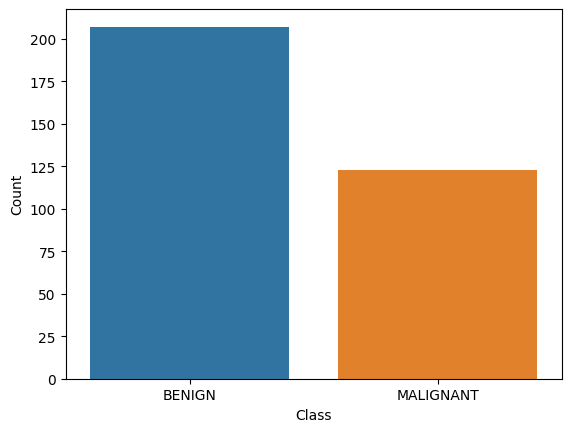

In [ ]:

class_counts = df['CLASS'].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')

In [ ]:
import cv2
import glob

# Đường dẫn đến thư mục chứa các tệp tin ảnh PGM
folder_path = '/content/mias-mammography/all-mias/'

# Lấy danh sách tệp tin PGM trong thư mục
pgm_files = glob.glob(folder_path + '*.pgm')

# Duyệt qua từng tệp tin PGM và chuyển đổi sang PNG
for pgm_file in pgm_files:
    # Đọc ảnh PGM
    image = cv2.imread(pgm_file, cv2.IMREAD_GRAYSCALE)

    # Tạo đường dẫn mới cho ảnh PNG
    png_file = pgm_file.replace('.pgm', '.png')

    # Ghi ảnh PNG
    cv2.imwrite(png_file, image)

In [ ]:
data = pd.read_csv('/content/mias-crop-mammography/description.csv')

BENIGN       207
MALIGNANT    115
Name: Classes, dtype: int64


Text(0, 0.5, 'Count')

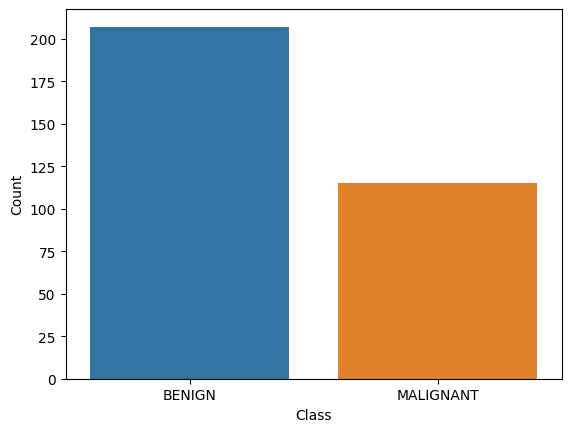

In [ ]:

data['Classes'] = ["BENIGN" if x == 'NORM' else "MALIGNANT" for x in data['Class']]
labels = data.drop_duplicates(subset=['Refnum'])['Class']
class_counts = data['Classes'].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')

In [ ]:
import pandas as pd
import os
import shutil

# Đường dẫn đến thư mục chứa ảnh
image_folder = '/content/mias-crop-mammography/images/'



# Đường dẫn đến thư mục BENIGN
benign_folder = '/content/mias-crop-mammography/BENIGN/'

# Đường dẫn đến thư mục MALIGNANT
malignant_folder = '/content/mias-crop-mammography/MALIGNANT/'


# Tạo thư mục BENIGN nếu chưa tồn tại
os.makedirs(benign_folder, exist_ok=True)

# Tạo thư mục MALIGNANT nếu chưa tồn tại
os.makedirs(malignant_folder, exist_ok=True)

# Áp dụng hàm lambda cho từng hàng trong dataframe
data.apply(lambda x: shutil.move(
    os.path.join(image_folder, x['Refnum']+'.png'),
    benign_folder if x['Classes'] == 'BENIGN' else malignant_folder
), axis=1)

0      /content/mias-crop-mammography/MALIGNANT/mdb00...
1      /content/mias-crop-mammography/MALIGNANT/mdb00...
2       /content/mias-crop-mammography/BENIGN/mdb003.png
3       /content/mias-crop-mammography/BENIGN/mdb004.png
4      /content/mias-crop-mammography/MALIGNANT/mdb00...
                             ...                        
317     /content/mias-crop-mammography/BENIGN/mdb318.png
318     /content/mias-crop-mammography/BENIGN/mdb319.png
319     /content/mias-crop-mammography/BENIGN/mdb320.png
320     /content/mias-crop-mammography/BENIGN/mdb321.png
321     /content/mias-crop-mammography/BENIGN/mdb322.png
Length: 322, dtype: object

In [ ]:
import pandas as pd
import os

# Đường dẫn đến thư mục BENIGN
benign_folder = '/content/mias-crop-mammography/BENIGN/'

# Đường dẫn đến thư mục MALIGNANT
malignant_folder = '/content/mias-crop-mammography/MALIGNANT/'

# Tạo cột mới "Path" và lưu đường dẫn vào đó
data['Path'] = data.apply(lambda row: os.path.join(benign_folder if row['Classes'] == 'BENIGN' else malignant_folder, row['Refnum'] + '.png'), axis=1)
data['Labels'] = data['Classes'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)
# Lưu lại tệp CSV đã cập nhật
data.to_csv('/content/mias-crop-mammography/description_new.csv', index=False)


In [ ]:
data.head()

,Refnum,Bg,Class,Severity,X,Y,Radius,Path,Cancer,Path_save,Classes,Labels
0,mdb001,G,CIRC,B,535.0,425.0,197.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb001.png,MALIGNANT,1
1,mdb002,G,CIRC,B,522.0,280.0,69.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb002.png,MALIGNANT,1
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,/content/mias-crop-mammography/BENIGN/mdb003.png,0,images/mdb003.png,BENIGN,0
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,/content/mias-crop-mammography/BENIGN/mdb004.png,0,images/mdb004.png,BENIGN,0
4,mdb005,F,CIRC,B,477.0,133.0,30.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb005.png,MALIGNANT,1


In [ ]:
import os
import random
import shutil

data_dir = "/content/mias-crop-mammography"
train_dir = "final_mias-crop-mammography/train"
test_dir = "final_mias-crop-mammography/valid"
train_ratio = 0.9


os.makedirs(os.path.join(train_dir, "BENIGN"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "MALIGNANT"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "BENIGN"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "MALIGNANT"), exist_ok=True)

benign_files = os.listdir(os.path.join(data_dir, "BENIGN"))
malignant_files = os.listdir(os.path.join(data_dir, "MALIGNANT"))

random.shuffle(benign_files)
random.shuffle(malignant_files)

train_benign_count = int(len(benign_files) * train_ratio)
train_malignant_count = int(len(malignant_files) * train_ratio)

for file in benign_files[:train_benign_count]:
    src = os.path.join(data_dir, "BENIGN", file)
    dst = os.path.join(train_dir, "BENIGN", file)
    shutil.copyfile(src, dst)

for file in benign_files[train_benign_count:]:
    src = os.path.join(data_dir, "BENIGN", file)
    dst = os.path.join(test_dir, "BENIGN", file)
    shutil.copyfile(src, dst)

for file in malignant_files[:train_malignant_count]:
    src = os.path.join(data_dir, "MALIGNANT", file)
    dst = os.path.join(train_dir, "MALIGNANT", file)
    shutil.copyfile(src, dst)

for file in malignant_files[train_malignant_count:]:
    src = os.path.join(data_dir, "MALIGNANT", file)
    dst = os.path.join(test_dir, "MALIGNANT", file)
    shutil.copyfile(src, dst)


In [ ]:
import torch
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
for param in model.parameters():
  param.requires_grad = True
model.classifier = nn.Linear(1280, 2)
net = model.to(DEVICE)
summary(model, (3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 63.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
BATCH_SIZE = 32
NUM_CLIENTS = 100
ORDER_of_CLIENTS = [80, 20]

def load_datasets(data_dirs):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    trainloaders = []
    valloaders = []

    for i,data_dir in enumerate(data_dirs):

        trainset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
        testset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['valid'])

        total_length = len(trainset)
        partition_size = total_length // ORDER_of_CLIENTS[i]
        lengths = [partition_size] * ORDER_of_CLIENTS[i]
        lengths[-1] = total_length - sum(lengths[:-1])

        clients_data = random_split(trainset, lengths, torch.Generator().manual_seed(42))

        client_trainloaders = []
        client_valloaders = []

        for client_data in clients_data:
            len_val = len(client_data) // 10
            len_train = len(client_data) - len_val
            lengths = [len_train, len_val]
            ds_train, ds_val = random_split(client_data, lengths, torch.Generator().manual_seed(42))
            trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
            client_trainloaders.append(trainloader)
            valloader = DataLoader(ds_val, batch_size=BATCH_SIZE)
            client_valloaders.append(valloader)

        trainloaders.extend(client_trainloaders)
        valloaders.extend(client_valloaders)

    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

data_dirs = ['/content/b_cancer_data', '/content/final_mias-crop-mammography']  # Thay đổi đường dẫn theo thư mục của bạn
trainloaders, valloaders, testloader = load_datasets(data_dirs)

In [ ]:
print(len(trainloaders))

100


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:

import csv

# Đường dẫn đến file CSV
csv_file_train = 'results_train.csv'
csv_file_test = 'results_test.csv'

class BNClient(fl.client.NumPyClient):
    # client_count = 0
    """Flower client implementing image classification using PyTorch."""
    def __init__(
        self,
        cid: str,
        model: net,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        num_examples: Dict,
        mode: str,
    ) -> None:
        self.cid = cid
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.num_examples = num_examples
        self.mode = mode
        # BNClient.client_count += 1
        # self.n_iter = BNClient.client_count


    def get_parameters(self, config) -> NDArrays:
        """Return model parameters as a list of NumPy ndarrays w or w/o using
        BN layers."""
        print(f"[Client {self.cid}] get_parameters")
        self.model.train()
        # pylint: disable = no-else-return
        if self.mode == "fedbn":
            # Excluding parameters of BN layers when using FedBN
            return [
                val.cpu().numpy()
                for name, val in self.model.state_dict().items()
                if "bn" not in name
            ]
        else:
            # Return all model parameters as a list of NumPy ndarrays
            return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters: NDArrays) -> None:
        """Set model parameters from a list of NumPy ndarrays Exclude the bn
        layer if available."""
        self.model.train()
        # pylint: disable=not-callable
        if self.mode == "fedbn":
            keys = [k for k in self.model.state_dict().keys() if "bn" not in k]
            params_dict = zip(keys, parameters)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            self.model.load_state_dict(state_dict, strict=False)
        else:
            params_dict = zip(self.model.state_dict().keys(), parameters)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            self.model.load_state_dict(state_dict, strict=True)
        # pylint: enable=not-callable

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[NDArrays, int, Dict]:
        """Set model parameters, train model, return updated model
        parameters."""
        print(f"[Client {self.cid}] fit, config: {config}")
        self.set_parameters(parameters)
        test_loss, test_accuracy = test(
            self.model, self.num_examples["dataset"], self.trainloader, device=DEVICE
        )
        test_dict = {
            "dataset": self.num_examples["dataset"],
            "fl_round": FL_ROUND,
            "strategy": self.mode,
            "train_loss": test_loss,
            "train_accuracy": test_accuracy,
        }
        loss, accuracy = train(
            self.model,
            self.trainloader,
            self.num_examples["dataset"],
            epochs=5,
            device=DEVICE,
        )
        eval_list.append(test_dict)

        # writer = SummaryWriter()


        eval_dict = eval_list[0]

        train_loss = eval_dict['train_loss']
        train_accuracy = eval_dict['train_accuracy']


        header_written = False

        with open(csv_file_train, 'a', newline='') as file:
          writer = csv.writer(file)

          if not header_written:
            writer.writerow(['train_loss', 'train_accuracy'])
            header_written = True

          writer.writerow([test_loss, test_accuracy])
        # # Ghi các giá trị vào TensorBoard
        # writer.add_scalar("loss/train", test_loss, self.n_iter)
        # writer.add_scalar("accuracy/train", test_accuracy, self.n_iter)
        # # n_iter += 1

        print("EVAL_LIST_FIT",eval_list)
        return (
            self.get_parameters({}),
            self.num_examples["trainset"],
            {"loss": loss, "accuracy": accuracy},
        )

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[float, int, Dict]:
        """Set model parameters, evaluate model on local test dataset, return
        result."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.set_parameters(parameters)
        global FL_ROUND

        loss, accuracy = test(
            self.model, self.num_examples["dataset"], self.testloader, device=DEVICE
        )
        test_dict = {
            "dataset": self.num_examples["dataset"],
            "fl_round": FL_ROUND,
            "strategy": self.mode,
            "test_loss": loss,
            "test_accuracy": accuracy,
        }
        eval_list.append(test_dict)
                # Truy cập vào từ điển trong danh sách eval_list
        eval_dict = eval_list[0]

        # Truy cập các giá trị 'test_loss' và 'test_accuracy' trong từ điển
        test_loss = eval_dict['test_loss']
        test_accuracy = eval_dict['test_accuracy']

        # Kiểm tra xem đã ghi tiêu đề cột hay chưa
        header_written = False

        with open(csv_file_test, 'a', newline='') as file:
          writer = csv.writer(file)

          if not header_written:
            writer.writerow(['test_loss', 'test_accuracy'])
            header_written = True

          # Ghi giá trị vào từng dòng
          writer.writerow([test_loss, test_accuracy])
        print("EVAL_LIST",eval_list)
        FL_ROUND += 1
        return (
            float(loss),
            self.num_examples["testset"],
            {"loss": loss, "accuracy": accuracy},
        )


In [ ]:
def train(model, traindata, dataset, epochs, device) -> Tuple[float, float]:
    """Train the network."""
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.006, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    # writer = SummaryWriter()
    print(
        f"Training {dataset} dataset with {epochs} local epoch(s) w/ {len(traindata)} batches each"
    )
    # n_iter = 1
    # Train the network
    model.to(device)
    model.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total = 0.0
        correct = 0
        for i, data in enumerate(traindata, 0):
            images, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # pylint: disable=no-member
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = running_loss
            accuracy = correct / total
            if i == len(traindata) - 1:  # print every 100 mini-batches
                accuracy = correct / total
                loss_batch = running_loss / len(traindata) # loss for mini batches
                # writer.add_scalar("loss/train",running_loss,n_iter)
                # writer.add_scalar("accuracy/train",accuracy,n_iter)
                print(
                    f"Train Dataset {dataset} with [{epoch+1}, {i+1}] \
                    loss: {loss_batch} accuracy: {accuracy}"
                )
                running_loss = 0.0
            # n_iter +=1
        loss = loss / len(traindata)
        exp_lr_scheduler.step()
    return loss, accuracy


def test(model, dataset, testdata, device) -> Tuple[float, float]:
    """Validate the network on the entire test set."""
    # Define loss and metrics
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    loss = 0.0

    # Evaluate the network
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in testdata:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)  # pylint: disable=no-member
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    loss = loss / len(testdata)
    print(f"Dataset {dataset} with evaluation loss: {loss}")
    return loss, accuracy



In [ ]:
FL_ROUND = 0
eval_list = []
# num_round = 0

def client_fn(cid: str) -> BNClient:
    """Create a Flower client representing a single organization."""
    # Load model
    net = model.to(DEVICE)

    num_round = 0
    print(f"ROUND BACK OTHER CLIENT {num_round}")
    num_round += 1  # Sử dụng toán tử += để tăng giá trị của biến num_round
    # Load data
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    num_examples = {
    "dataset": "HBCDs",
    "trainset": len(trainloader),
    "testset": len(valloader),
}
    # Create a  single Flower client representing a single organization
    return BNClient(cid,net, trainloader, valloader,num_examples,"fedbn")

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedBN strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=10,
    min_evaluate_clients=1,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = {"num_cpus" : 2}
if DEVICE.type == "cuda":
    print("Using GPU")
    client_resources = {"num_gpus": 1}


# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=60),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-08-24 09:07:59,754 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-08-24 09:08:05,389	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-08-24 09:08:07,229 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3915573657.0, 'memory': 7831147316.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3915573657.0, 'memory': 7831147316.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-08-24 09:08:07,233 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-08-24 09:08:07,236 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random clien

(launch_and_get_parameters pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_get_parameters pid=2951) [Client 58] get_parameters
(launch_and_fit pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=2951) [Client 24] fit, config: {}
(launch_and_fit pid=2951) Dataset HBCDs with evaluation loss: 0.6593833367029825
(launch_and_fit pid=2951) Training HBCDs dataset with 5 local epoch(s) w/ 3 batches each
(launch_and_fit pid=2951) Train Dataset HBCDs with [1, 3]                     loss: 0.595499575138092 accuracy: 0.7222222222222222
(launch_and_fit pid=2951) Train Dataset HBCDs with [2, 3]                     loss: 0.5342869162559509 accuracy: 0.75
(launch_and_fit pid=2951) Train Dataset HBCDs with [3, 3]                     loss: 0.5252782007058462 accuracy: 0.8055555555555556
(launch_and_fit pid=2951) Train Dataset HBCDs with [4, 3]                     loss: 0.37545205156008404 accuracy: 0.875
(launch_and_fit pid=2951) Train Dataset HBCDs with [5, 3]                     loss: 0.6798313756

DEBUG flwr 2023-08-24 10:45:52,930 | server.py:232 | fit_round 1 received 100 results and 0 failures
DEBUG:flwr:fit_round 1 received 100 results and 0 failures


(launch_and_fit pid=2951) Train Dataset HBCDs with [5, 3]                     loss: 0.24231798450152078 accuracy: 0.9166666666666666
(launch_and_fit pid=2951) EVAL_LIST_FIT [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'train_loss': 0.6587111353874207, 'train_accuracy': 0.6111111111111112}]
(launch_and_fit pid=2951) [Client 36] get_parameters


WARNING flwr 2023-08-24 10:46:00,494 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 10:46:00,512 | server.py:168 | evaluate_round 1: strategy sampled 100 clients (out of 100)
DEBUG:flwr:evaluate_round 1: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.029656633734703064
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.029656633734703064, 'test_accuracy': 1.0}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.7813881039619446
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.7813881039619446, 'test_accuracy': 0.7142857142857143}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 1.2250934839248657
(launch_and_evaluate pid=2951) EVAL_LIST [{'datase

DEBUG flwr 2023-08-24 10:47:00,570 | server.py:182 | evaluate_round 1 received 100 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 100 results and 0 failures
DEBUG flwr 2023-08-24 10:47:00,574 | server.py:218 | fit_round 2: strategy sampled 100 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.2574920654296875
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.2574920654296875, 'test_accuracy': 1.0}]
(launch_and_fit pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=2951) [Client 14] fit, config: {}
(launch_and_fit pid=2951) Dataset HBCDs with evaluation loss: 0.5495376686255137
(launch_and_fit pid=2951) Training HBCDs dataset with 5 local epoch(s) w/ 3 batches each
(launch_and_fit pid=2951) Train Dataset HBCDs with [1, 3]                     loss: 0.534538189570109 accuracy: 0.7638888888888888
(launch_and_fit pid=2951) Train Dataset HBCDs with [2, 3]                     loss: 0.4497026205062866 accuracy: 0.7916666666666666
(launch_and_fit pid=2951) Train Dataset HBCDs with [3, 3]                     loss: 0.3108542412519455 accuracy: 0.9027777777777778
(launch_and_fit pid=2951) Train Dataset HBCDs with [4, 3]                     loss: 0.26

DEBUG flwr 2023-08-24 12:36:30,487 | server.py:232 | fit_round 2 received 100 results and 0 failures
DEBUG:flwr:fit_round 2 received 100 results and 0 failures


(launch_and_fit pid=2951) Train Dataset HBCDs with [5, 3]                     loss: 0.07987492034832637 accuracy: 1.0
(launch_and_fit pid=2951) EVAL_LIST_FIT [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'train_loss': 0.35733341177304584, 'train_accuracy': 0.875}]
(launch_and_fit pid=2951) [Client 8] get_parameters


DEBUG flwr 2023-08-24 12:36:40,441 | server.py:168 | evaluate_round 2: strategy sampled 100 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.2604697644710541
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.2604697644710541, 'test_accuracy': 0.8571428571428571}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.5871587991714478
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.5871587991714478, 'test_accuracy': 1.0}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.5261067748069763
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 

DEBUG flwr 2023-08-24 12:37:41,337 | server.py:182 | evaluate_round 2 received 100 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 100 results and 0 failures
DEBUG flwr 2023-08-24 12:37:41,342 | server.py:218 | fit_round 3: strategy sampled 100 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.4229704439640045
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.4229704439640045, 'test_accuracy': 0.8571428571428571}]
(launch_and_fit pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=2951) [Client 87] fit, config: {}
(launch_and_fit pid=2951) Dataset HBCDs with evaluation loss: 0.6769170165061951
(launch_and_fit pid=2951) Training HBCDs dataset with 5 local epoch(s) w/ 1 batches each
(launch_and_fit pid=2951) Train Dataset HBCDs with [1, 1]                     loss: 1.5925419330596924 accuracy: 0.23076923076923078
(launch_and_fit pid=2951) Train Dataset HBCDs with [2, 1]                     loss: 0.5290429592132568 accuracy: 0.8461538461538461
(launch_and_fit pid=2951) Train Dataset HBCDs with [3, 1]                     loss: 0.4509533643722534 accuracy: 0.7692307692307693
(launch_and_fit pid=2951) Train Dataset HBCDs with [4, 1]              

DEBUG flwr 2023-08-24 14:23:27,329 | server.py:232 | fit_round 3 received 100 results and 0 failures
DEBUG:flwr:fit_round 3 received 100 results and 0 failures


(launch_and_fit pid=2951) Train Dataset HBCDs with [5, 1]                     loss: 0.5819547176361084 accuracy: 0.5384615384615384
(launch_and_fit pid=2951) EVAL_LIST_FIT [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'train_loss': 0.6412168741226196, 'train_accuracy': 0.5384615384615384}]
(launch_and_fit pid=2951) [Client 89] get_parameters


DEBUG flwr 2023-08-24 14:23:37,693 | server.py:168 | evaluate_round 3: strategy sampled 100 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.5416182279586792
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.5416182279586792, 'test_accuracy': 0.7142857142857143}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.2261204719543457
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.2261204719543457, 'test_accuracy': 0.8571428571428571}]
(launch_and_evaluate pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_evaluate pid=2951) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.5177348852157593
(launch_and_evaluate pid=2951) EVAL_LIS

DEBUG flwr 2023-08-24 14:24:37,380 | server.py:182 | evaluate_round 3 received 100 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 100 results and 0 failures
DEBUG flwr 2023-08-24 14:24:37,385 | server.py:218 | fit_round 4: strategy sampled 100 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 100 clients (out of 100)


(launch_and_evaluate pid=2951) Dataset HBCDs with evaluation loss: 0.12115556746721268
(launch_and_evaluate pid=2951) EVAL_LIST [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 0.12115556746721268, 'test_accuracy': 1.0}]
(launch_and_fit pid=2951) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=2951) [Client 93] fit, config: {}
(launch_and_fit pid=2951) Dataset HBCDs with evaluation loss: 0.48650476336479187
(launch_and_fit pid=2951) Training HBCDs dataset with 5 local epoch(s) w/ 1 batches each
(launch_and_fit pid=2951) Train Dataset HBCDs with [1, 1]                     loss: 1.7321231365203857 accuracy: 0.3076923076923077
(launch_and_fit pid=2951) Train Dataset HBCDs with [2, 1]                     loss: 0.5791503190994263 accuracy: 0.6923076923076923
(launch_and_fit pid=2951) Train Dataset HBCDs with [3, 1]                     loss: 0.5616052746772766 accuracy: 0.7692307692307693
(launch_and_fit pid=2951) Train Dataset HBCDs with [4, 1]                     loss: 

ERROR flwr 2023-08-24 15:21:31,107 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 284727c58bf996a412d2b883aa5bf57a1943c709dbdaa69932a9efae) where the task (task ID: 266d08d2b468d545570721718cdaa07a0ea3ef2101000000, name=launch_and_fit, pid=2951, memory used=4.09GB) was running was 12.06GB / 12.68GB (0.950972), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 7cf68ae7be52444fade4c465a39f5d908a329fbe441013f7e3b9f3d0) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-7cf68ae7be52444fade4c465a39f5d908a329fbe441013f7e3b9f3d0*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
581	5.05	/usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-c95dc878-399e-47...
2951	4.09	ray::launch_and_fit
79	0.11	/usr/

(launch_and_fit pid=92101) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=92101) [Client 15] fit, config: {}
(launch_and_fit pid=92101) Dataset HBCDs with evaluation loss: 0.21698181331157684
(launch_and_fit pid=92101) Training HBCDs dataset with 5 local epoch(s) w/ 3 batches each


(raylet) [2023-08-24 15:22:05,888 E 2893 2893] (raylet) node_manager.cc:3084: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 284727c58bf996a412d2b883aa5bf57a1943c709dbdaa69932a9efae, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=92101) Train Dataset HBCDs with [1, 3]                     loss: 0.2601291040579478 accuracy: 0.8888888888888888
(launch_and_fit pid=92101) Train Dataset HBCDs with [2, 3]                     loss: 0.17689304798841476 accuracy: 0.9444444444444444
(launch_and_fit pid=92101) Train Dataset HBCDs with [3, 3]                     loss: 0.16511793931325278 accuracy: 0.9444444444444444
(launch_and_fit pid=92101) Train Dataset HBCDs with [4, 3]                     loss: 0.19655541082223257 accuracy: 0.9166666666666666
(launch_and_fit pid=92101) Train Dataset HBCDs with [5, 3]                     loss: 0.11629275729258855 accuracy: 0.9583333333333334
(launch_and_fit pid=92101) EVAL_LIST_FIT [{'dataset': 'HBCDs', 'fl_round': 0, 'strategy': 'fedbn', 'train_loss': 0.21698181331157684, 'train_accuracy': 0.875}]
(launch_and_fit pid=92101) [Client 15] get_parameters
(launch_and_fit pid=92101) ROUND BACK OTHER CLIENT 0
(launch_and_fit pid=92101) [Client 9] fit, config: {}
(launch_an

In [ ]:
print(history)

NameError: ignored

In [ ]:
with open('Histopathological Breast Cancer Dataset_FedBN_results.json', 'w') as fp:
    pass

In [ ]:
with open(
    "Histopathological Breast Cancer Dataset_FedBN_results.json", mode="r+"
) as eval_file:
    json.dump(eval_list, eval_file)

In [ ]:
import pickle
import matplotlib.pyplot as plt


with open('Loss_breakHis_dataset.pkl', 'wb') as file:
    pickle.dump((history), file)

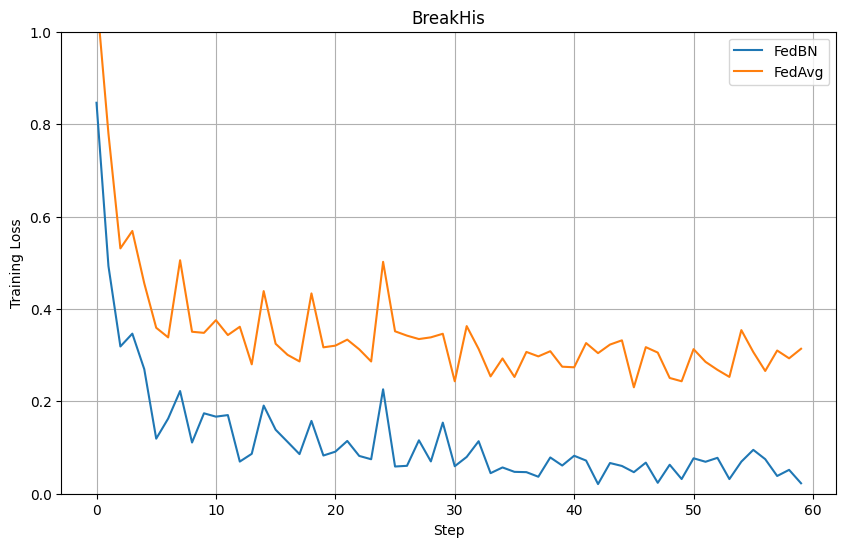

In [ ]:
# Đọc dữ liệu từ file pickle
with open('Loss_breakHis_dataset.pkl', 'rb') as file:
    read_data_1, read_data_2 = pickle.load(file)

# Số lượng epochs
epochs = 60
plt.figure(figsize=(10, 6))
# Tạo list chứa giá trị x-axis từ 0 đến epochs-1
x = list(range(epochs))

plt.ylim(bottom=0, top=1)
plt.grid(True)
# Vẽ đồ thị
plt.plot(x, read_data_1, label='FedBN')
plt.plot(x, read_data_2, label='FedAvg')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('BreakHis')
plt.legend()
plt.show()